##Target:

- Add Dropout in each layer , FC layers after Avg GAP layer  to increase model efficiency.



# Import Libraries

Let's first import all the necessary libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# Defining Model
 Create a CNN Model 

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        drop = 0.02  # droput value
        # Input Block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 26    RF:  2

        # CONVOLUTION BLOCK 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop)
        ) # output_size = 24 RF: 5

        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12    RF:  6

        # TRANSITION BLOCK 1
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU()
        ) # output_size = 12    RF:  6

        # CONVOLUTION BLOCK 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=(3, 3), padding=0, bias=False), # output_size = 10    RF:  10
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=12, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # output_size = 8    RF: 14
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=(3, 3), padding=0, bias=False), # output_size = 6    RF: 18
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.Dropout(drop)
        ) 
        
        # Global average pooling
        self.gap = nn.Sequential(
            nn.AvgPool2d(6)  # output_size = 1    RF:  28
        )

        # Fully connected layer
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=(1, 1), padding=0, bias=False), # output_size = 1    RF: 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(drop),
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),  # output  RF: 28
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.trans1(x)
        x = self.conv3(x)
        x = self.gap(x)
        x = self.conv4(x)
        x = x.view(-1, 10)   # convert 2D to 1D
        
        return F.log_softmax(x, dim=-1)

# Model Summary
 To view and to understand Model Trainable parameteres

In [3]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
              ReLU-3            [-1, 8, 26, 26]               0
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
           Conv2d-13           [-1, 12, 10, 10]             864
      BatchNorm2d-14           [-1, 12,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([         
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)




  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CUDA Available? False


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Training & Testing Functions
 Creating Training and Testing functions.

In [5]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Train & Test our Model
 Let's train and test our model

In [6]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.24073980748653412 Batch_id=937 Accuracy=92.15: 100%|██████████| 938/938 [01:02<00:00, 15.03it/s]



Test set: Average loss: 0.0817, Accuracy: 9741/10000 (97.41%)

EPOCH: 2


Loss=0.08073828369379044 Batch_id=937 Accuracy=97.65: 100%|██████████| 938/938 [01:02<00:00, 15.07it/s]



Test set: Average loss: 0.0377, Accuracy: 9890/10000 (98.90%)

EPOCH: 3


Loss=0.03231639042496681 Batch_id=937 Accuracy=98.25: 100%|██████████| 938/938 [01:02<00:00, 15.02it/s]



Test set: Average loss: 0.0306, Accuracy: 9912/10000 (99.12%)

EPOCH: 4


Loss=0.0024427156895399094 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [01:02<00:00, 14.92it/s]



Test set: Average loss: 0.0356, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.031800609081983566 Batch_id=937 Accuracy=98.67: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]



Test set: Average loss: 0.0348, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.027378886938095093 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:02<00:00, 14.92it/s]



Test set: Average loss: 0.0242, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.005746602546423674 Batch_id=937 Accuracy=98.86: 100%|██████████| 938/938 [01:02<00:00, 14.96it/s]



Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

EPOCH: 8


Loss=0.13078981637954712 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [01:03<00:00, 14.85it/s]



Test set: Average loss: 0.0241, Accuracy: 9929/10000 (99.29%)

EPOCH: 9


Loss=0.029190130531787872 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]



Test set: Average loss: 0.0231, Accuracy: 9915/10000 (99.15%)

EPOCH: 10


Loss=0.08293239027261734 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s]



Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

EPOCH: 11


Loss=0.32081925868988037 Batch_id=937 Accuracy=99.11: 100%|██████████| 938/938 [01:02<00:00, 14.95it/s]



Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

EPOCH: 12


Loss=0.0010711266659200191 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:02<00:00, 14.91it/s]



Test set: Average loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 13


Loss=0.014165733009576797 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.012291204184293747 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:03<00:00, 14.73it/s]



Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 15


Loss=0.0015296960482373834 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:03<00:00, 14.82it/s]



Test set: Average loss: 0.0228, Accuracy: 9933/10000 (99.33%)



# Observation


Text(0.5, 1.0, 'Test Accuracy')

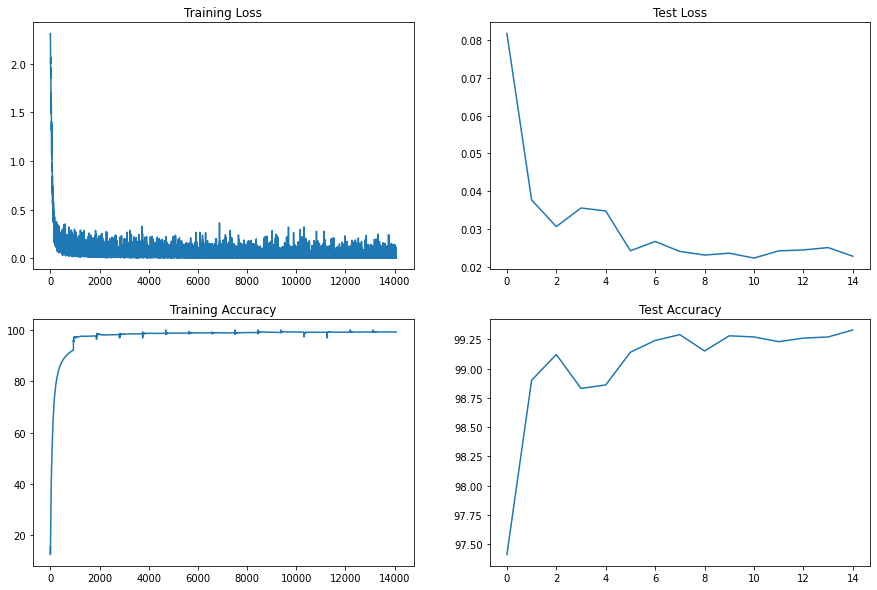

In [7]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Results:


-   Parameters: 7496
-   Best Train Accuracy: 99.18%
-   Best Test Accuracy: 99.33%

## Analysis:


-   There is slight decrease in the number of parameters, also accuracy decreased while we add dropout at each layer and used GAP before a convolution layer 
-   Model problem is rectified to an extent we got train accuracy to 99.18% whereas the test accuracy is 99.33%. But, we have not reached the target test accuracy 99.40%.